# ANALYTIC SPECTRAL DENSITIES

## No Smearing

We have, for non-subtracted spectral densities, that: 
$$C(t) = C_0 e^{-m_0 t} + C_1 e^{-m_1 t} = \int_0^{+\infty}d\omega\,\rho(\omega)e^{-\omega t} \qquad\rightarrow\qquad \rho(\omega) = C_0 \delta(\omega - m_0) + C_1\delta(\omega - m_1)$$

For the vector current, we have the subtracted:
$$C(t) = \int_0^{+\infty}d\omega\, \rho(\omega)\omega^2 e^{-\omega t} \qquad\rightarrow\qquad \rho(\omega)\omega^2 = C_0 \delta(\omega - m_0) + C_1\delta(\omega - m_1)\qquad\rightarrow\qquad \rho(\omega) = \frac{C_0}{m_0^2}\delta(\omega - m_0) + \frac{C_1}{m_1^2}\delta(\omega - m_1)$$

In the case where $\sigma = 0$, we can't consider $\alpha = 0$. We have that:
$$\rho_\alpha (\omega) = \int_0^{+\infty}d\omega'\,\delta_\alpha(\omega, \omega')\rho(\omega') = \frac{C_0}{m_0^2}\delta_\alpha(\omega, m_0) + \frac{C_1}{m_1^2}\delta_\alpha(\omega, m_1).$$
The propagation of the errors is given by:
$$\begin{align}J &= \biggl(\frac{\partial\rho_\alpha}{\partial C_0}, \frac{\partial\rho_\alpha}{\partial m_0}, \frac{\partial\rho_\alpha}{\partial C_1}, \frac{\partial\rho_\alpha}{\partial m_1}\biggr) \\
\frac{\partial\rho}{\partial C_0} &= \frac{1}{m_0^2} \delta_\alpha(\omega, m_0) \\
\frac{\partial\rho}{\partial m_0} &= C_0\biggl(\frac{1}{m_0^2}\frac{\partial}{\partial m_0}\delta_\alpha(\omega, m_0) - \frac{2}{m_0^3}\delta_\alpha(\omega, m_0)\biggr)\\
\frac{\partial\rho}{\partial C_1} &= \frac{1}{m_1^2} \delta_\alpha(\omega, m_1) \\
\frac{\partial\rho}{\partial m_1} &= C_1\biggl(\frac{1}{m_1^2}\frac{\partial}{\partial m_1}\delta_\alpha(\omega, m_1) - \frac{2}{m_1^3}\delta_\alpha(\omega, m_1)\biggr)
\end{align}$$
with
$$\frac{\partial}{\partial m}\delta_\alpha(\omega, m) = \int_{-\infty}^{+\infty} ds\,\biggl(\frac{-1/2 + is}{m}\biggr)\frac{u_s^*(\omega)|\lambda_s|^2u_s(m)}{|\lambda_s|^2 + \alpha}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
from scipy.special import gamma
import mpmath
from spectral_density import *

In [2]:
data = open("out/vector/data/fits/direct_fit_double.txt")
lines = data.readlines()
data.close()

par = []
for l in lines:
    t = l.split()
    if int(t[0]) == 10:
        for i in range(4):
            par.append(float(t[1 + 2*i]))
        break
par = np.array(par)

data = open("out/vector/data/fits/cov.txt")
cov = np.zeros((len(par), len(par)))
for i in range(len(par)):
    for j in range(len(par)):
        cov[i, j] = float(data.readline().split()[0])
data.close()

In [3]:
alpha = [1e-6, 1e-9, 1e-12]

/data/knuth/home/dtoniolo/Analysis_spectral_densities/spectral_density.py:150: RuntimeWarning: overflow encountered in cosh
  return np.pi/(np.pi + a*np.cosh(np.pi * s))


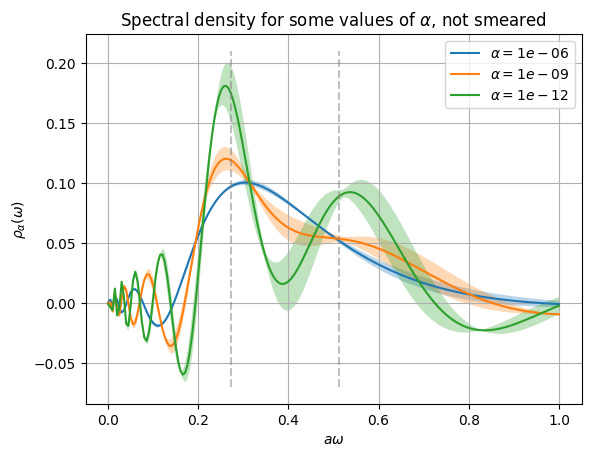

In [4]:
x = np.linspace(0.0001, 1, 200)
for a in alpha:
    y = []
    y_err = []
    for i in x:
        y.append(SDan().rho(i, par, a))
        y_err.append(SDan().err_rho(i, par, a, cov))
    plt.plot(x, y, label=r"$\alpha = {}$".format(a))
    plt.fill_between(x, np.array(y)+np.array(y_err), np.array(y)-np.array(y_err), alpha = 0.3)

m1, m2 = np.zeros(1000), np.zeros(1000)
for i in range(len(m1)):
    m1[i] = par[1]
    m2[i] = par[3]
vert = np.linspace(-0.070, 0.210, 1000)
plt.plot(m1, vert, linestyle = "dashed", color = "grey", alpha = 0.5)
plt.plot(m2, vert, linestyle = "dashed", color = "grey", alpha = 0.5)
plt.legend()
plt.xlabel(r"$a\omega$")
plt.ylabel(r"$\rho_\alpha(\omega)$")
plt.grid()
plt.title(r"Spectral density for some values of $\alpha$, not smeared")
plt.savefig("Not_smeared_spectral_densities.png")

## With Smearing

If we consider a smearing with a gaussian distribution, $N_{m_1, \sigma}(\omega)$, we get, if $\alpha = 0$:
$$\rho_\sigma(\omega) = \frac{C_0}{m_0^2}N_{m_0, \sigma}(\omega) + \frac{C_1}{m_1^2}N_{m_1, \sigma}(\omega)$$

To propagate the errors, we need to compute the jacobian. We get:
$$\begin{align}J &= \biggl(\frac{\partial\rho}{\partial C_0}, \frac{\partial\rho}{\partial m_0}, \frac{\partial\rho}{\partial C_1}, \frac{\partial\rho}{\partial m_1}\biggr) \\
\frac{\partial\rho}{\partial C_0} &= \frac{1}{m_0^2} N_{m_0, \sigma}(\omega) \\
\frac{\partial\rho}{\partial m_0} &= C_0\Bigl(-\frac{2}{m_0^3} +\frac{(\omega - m_0)}{\sigma^2m_0^2}\Bigr)N_{m_0, \sigma}(\omega) \\
\frac{\partial\rho}{\partial C_1} &= \frac{1}{m_1^2} N_{m_1, \sigma}(\omega) \\
\frac{\partial\rho}{\partial m_1} &= C_1\Bigl(-\frac{2}{m_1^3} +\frac{(\omega - m_1)}{\sigma^2m_1^2}\Bigr)N_{m_1 \sigma}(\omega)
\end{align}$$
and the error on $\rho$ is $J^T C J$.

If $\alpha \neq 0$ instead, we have:
$$\rho_{\sigma, \alpha} (\omega) = \int_0^{+\infty}d\omega'd\omega''\,\rho(\omega')\delta_\alpha(\omega', \omega'')N_{\omega, \sigma}(\omega'') = \frac{C_0}{m_0^2}K_{\sigma, \alpha}(m_0, \omega) + \frac{C_1}{m_1^2}K_{\sigma, \alpha}(m_0, \omega),$$
with
$$K_{\sigma, \alpha}(\omega, \omega') = \int_0^{+\infty}d\omega'' \delta_\alpha(\omega,\omega'')N_{\omega', \sigma}(\omega'') = \int ds\frac{u_s^*(\omega)|\lambda_s|^2}{|\lambda_s|^2 + \alpha}\biggl(\int_0^{+\infty}d\omega''u_s(\omega'')N_{\omega', \sigma}(\omega'')\biggr) $$
The propagation of the errors is given by:
$$\begin{align}J &= \biggl(\frac{\partial\rho_{\sigma, \alpha}}{\partial C_0}, \frac{\partial\rho_{\sigma, \alpha}}{\partial m_0}, \frac{\partial\rho_{\sigma, \alpha}}{\partial C_1}, \frac{\partial\rho_{\sigma, \alpha}}{\partial m_1}\biggr) \\
\frac{\partial\rho}{\partial C_0} &= \frac{1}{m_0^2} K_{\sigma, \alpha}(m_0, \omega) \\
\frac{\partial\rho}{\partial m_0} &= C_0\biggl(\frac{1}{m_0^2}\frac{\partial}{\partial m_0}K_{\sigma, \alpha}(m_0, \omega) - \frac{2}{m_0^3}K_{\sigma, \alpha}(m_0, \omega)\biggr)\\
\frac{\partial\rho}{\partial C_1} &= \frac{1}{m_1^2} K_{\sigma, \alpha}(m_1, \omega) \\
\frac{\partial\rho}{\partial m_1} &= C_1\biggl(\frac{1}{m_1^2}\frac{\partial}{\partial m_1}K_{\sigma, \alpha}(m_1, \omega) - \frac{2}{m_1^3}K_{\sigma, \alpha}(m_1, \omega)\biggr)
\end{align}$$
with
$$\frac{\partial}{\partial m}K_{\sigma, \alpha}(m, \omega) = \int ds\biggl(\frac{-1/2-is}{m}\biggr)\frac{u_s^*(m)|\lambda_s|^2}{|\lambda_s|^2 + \alpha}\biggl(\int_0^{+\infty}d\omega''u_s(\omega'')N_{\omega, \sigma}(\omega'')\biggr)$$

In [11]:
alpha_s = [0, 1e-6, 1e-9, 1e-12]
width = [135.0/2.0, 135, 270, 540, 810]
scan = 101

In [12]:
x = np.linspace(0.05, 1, scan)
sp_av = np.zeros((len(width), len(alpha_s), len(x)))
sp_err = np.zeros((len(width), len(alpha_s), len(x)))

for i in range(len(width)):
    s = width[i] * 0.065/197.3
    for j in range(len(alpha_s)):
        for w in range(len(x)):
            sp_av[i, j, w] = SDan_sm().rho(x[w], par, alpha_s[j], s)
            sp_err[i, j, w] = SDan_sm().err_rho(x[w], par, alpha_s[j], s, cov)

out = open("out/vector/data/rho/smeared_sp.txt", "w")
for i in range(len(width)):
    for j in range(len(alpha_s)):
        for w in range(len(x)):
            print(sp_av[i, j, w], sp_err[i, j, w], file=out)
out.close()

In [ ]:
x = np.linspace(0, 1, scan)
sp_av = np.zeros((len(width), len(alpha_s), len(x)))
sp_err = np.zeros((len(width), len(alpha_s), len(x)))

input = open("out/vector/data/rho/smeared_sp.txt", "r")
for i in range(len(width)):
    for j in range(len(alpha_s)):
        for w in range(len(x)):
            l = input.readline().split()
            if l != []:
                sp_av[i, j, w] = float(l[0])
                sp_err[i, j, w] = float(l[1])
            
input.close()

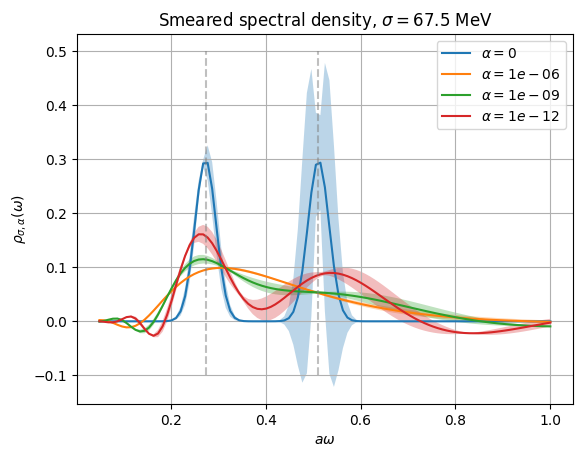

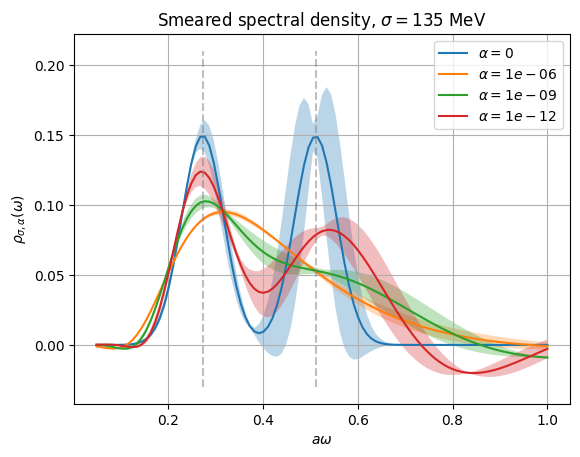

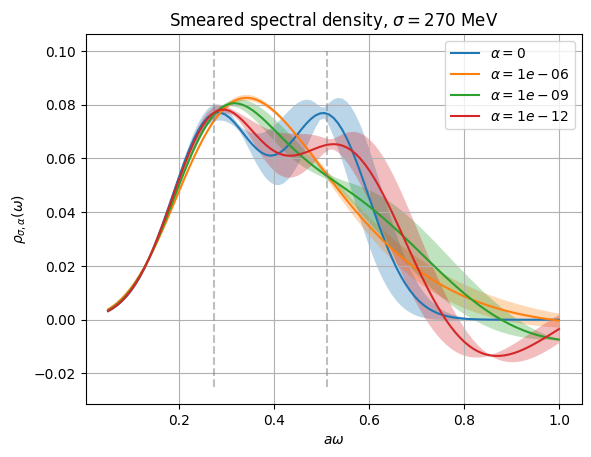

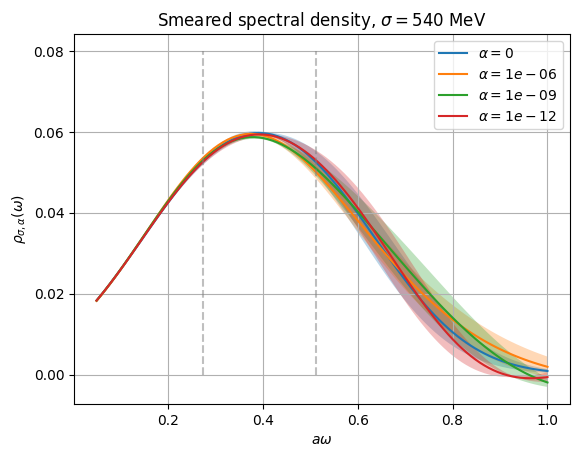

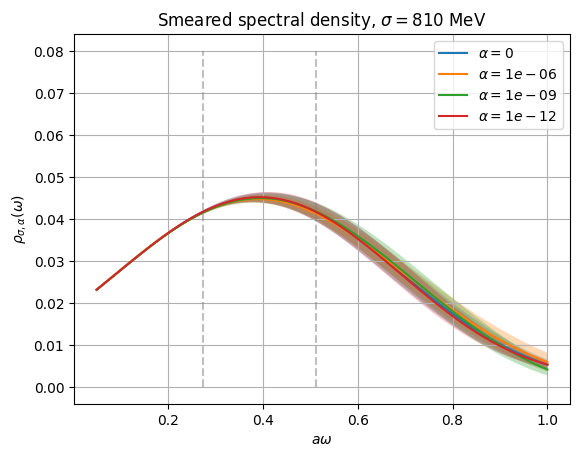

In [13]:
up_lim=[0.5, 0.210, 0.10, 0.08, 0.08]
lo_lim=[-0.1, -0.03, -0.025, 0.0, 0.0]
for i in range(len(width)):
    plt.title(r"Smeared spectral density, $\sigma = {}$ MeV".format(width[i]))
    for j in range(len(alpha_s)):
        plt.plot(x, sp_av[i, j, :], label = r"$\alpha = {}$".format(alpha_s[j]))
        plt.fill_between(x, sp_av[i, j, :] + sp_err[i, j, :], sp_av[i, j, :] - sp_err[i, j, :], alpha = 0.3)
    m1, m2 = np.zeros(10), np.zeros(10)
    for j in range(len(m1)):
        m1[j] = par[1]
        m2[j] = par[3]
    vert = np.linspace(lo_lim[i], up_lim[i], 10)
    plt.plot(m1, vert, linestyle = "dashed", color = "grey", alpha = 0.5)
    plt.plot(m2, vert, linestyle = "dashed", color = "grey", alpha = 0.5)
    plt.legend()
    plt.xlabel(r"$a\omega$")
    plt.ylabel(r"$\rho_{\sigma, \alpha}(\omega)$")
    plt.grid()
    plt.show()

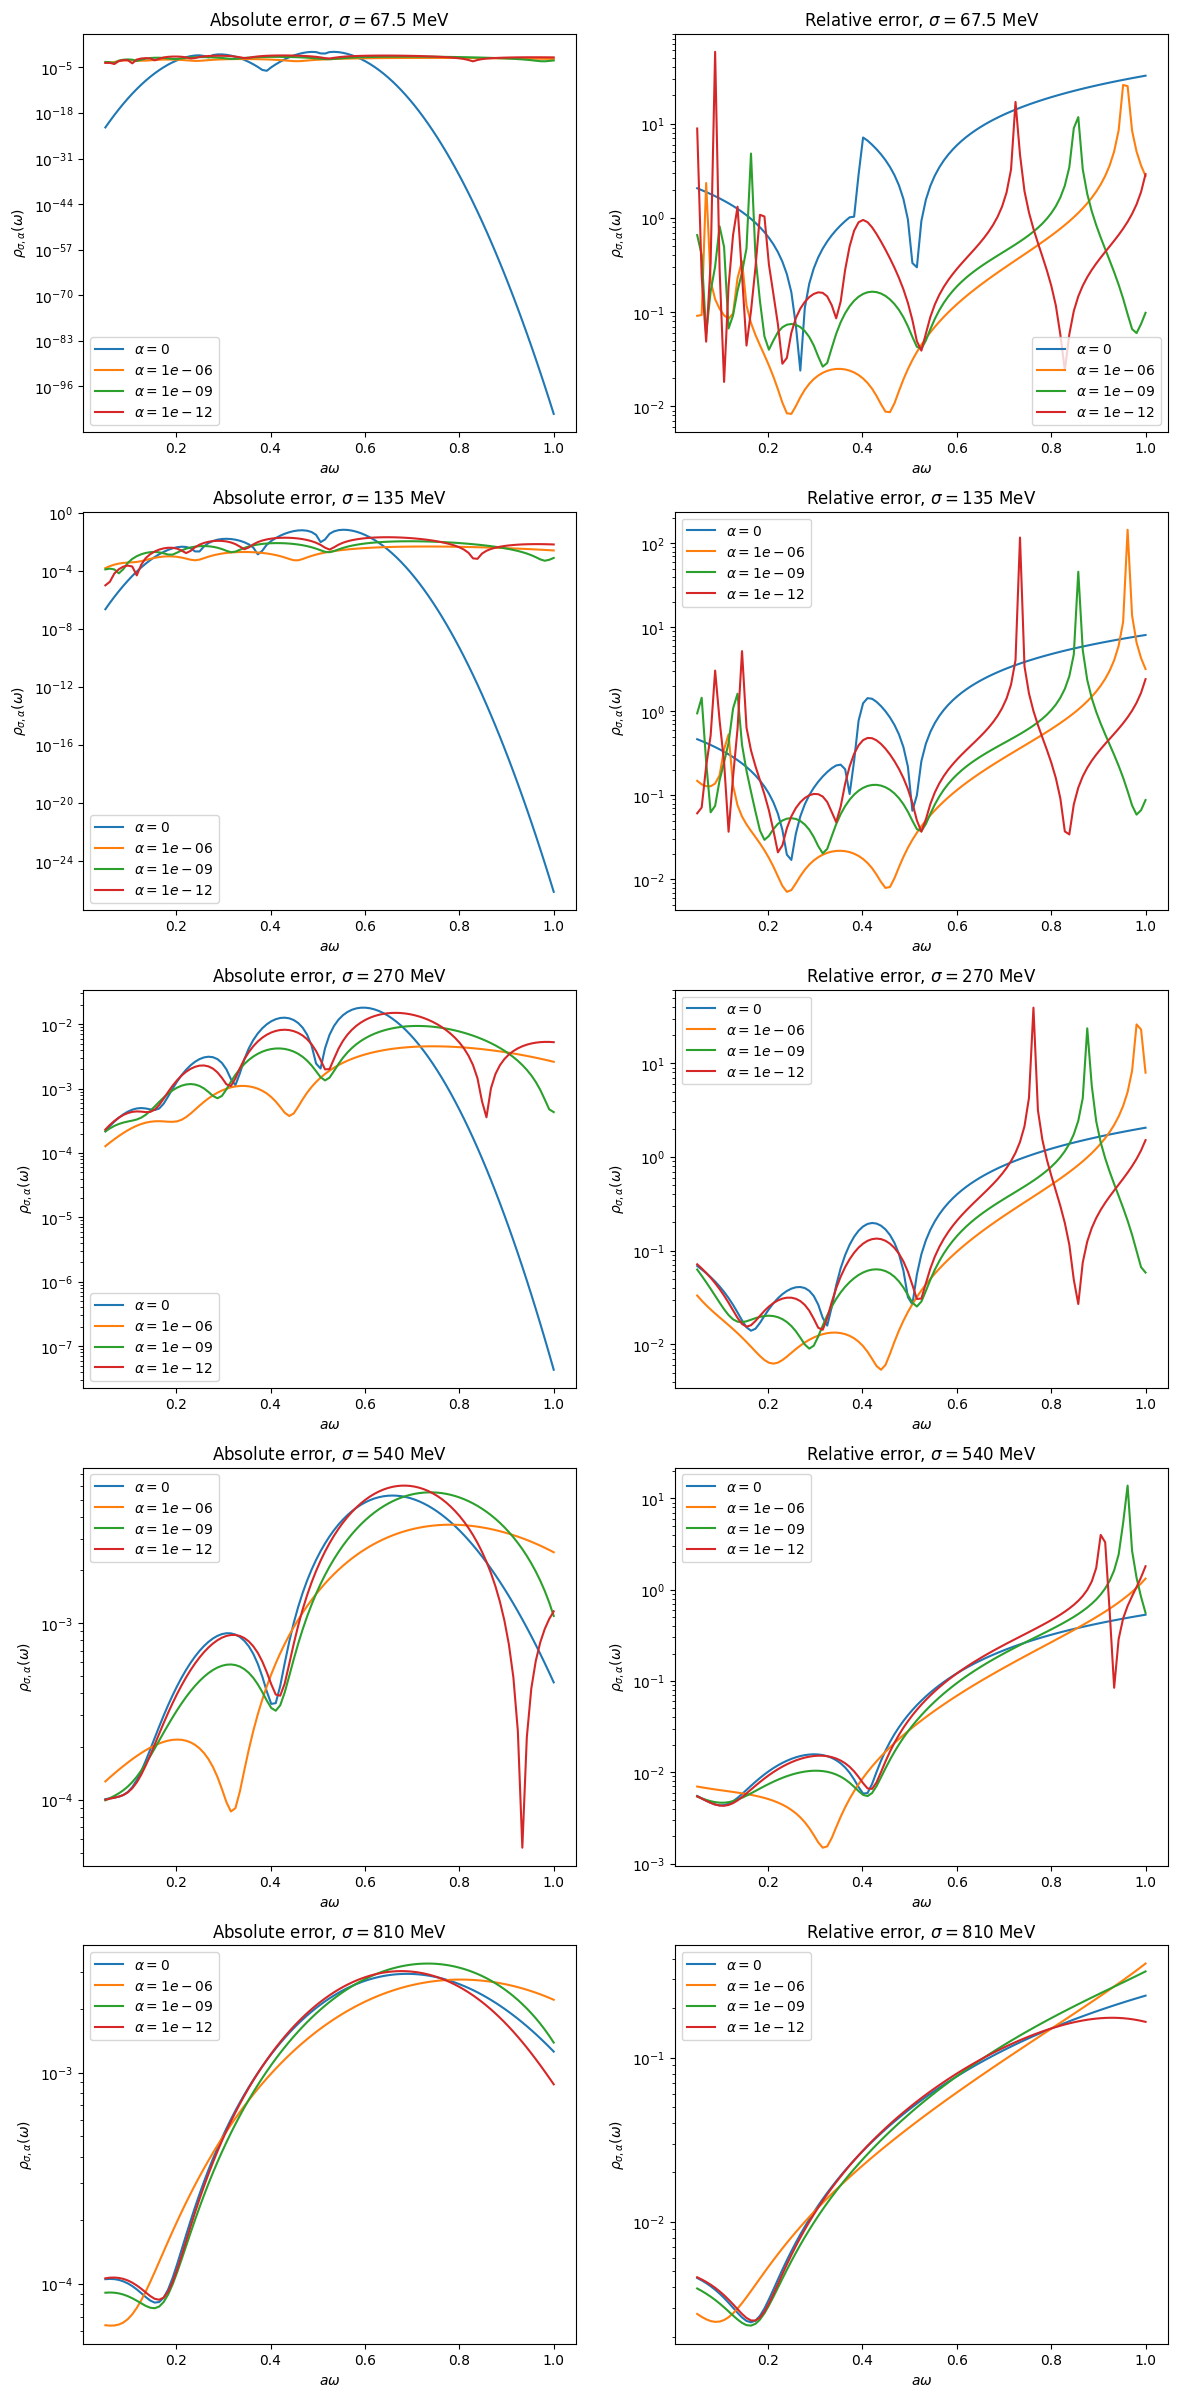

In [14]:
plt.figure(figsize=[14, 6*len(width)])
up_lim=[0.5, 0.210, 0.10, 0.08, 0.08]
lo_lim=[-0.1, -0.03, -0.025, 0.0, 0.0]
for i in range(len(width)):
    plt.subplot(len(width), 2, 2*i+1)
    plt.title(r"Absolute error, $\sigma = {}$ MeV".format(width[i]))
    for j in range(len(alpha_s)):
        plt.plot(x, sp_err[i, j, :], label = r"$\alpha = {}$".format(alpha_s[j]))
    plt.semilogy()
    plt.legend()
    plt.xlabel(r"$a\omega$")
    plt.ylabel(r"$\rho_{\sigma, \alpha}(\omega)$")
    plt.subplot(len(width), 2, 2*(i+1))
    plt.title(r"Relative error, $\sigma = {}$ MeV".format(width[i]))
    for j in range(len(alpha_s)):
        plt.plot(x, np.abs(sp_err[i, j, :]/sp_av[i, j, :]), label = r"$\alpha = {}$".format(alpha_s[j]))
    plt.semilogy()
    plt.legend()
    plt.xlabel(r"$a\omega$")
    plt.ylabel(r"$\rho_{\sigma, \alpha}(\omega)$")
plt.savefig("Error_plots.png")